In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Scalable Gaussian processes in PyMC3

PyMC3 has support for [Gaussian Processes (GPs)](https://docs.pymc.io/gp.html), but this implementation is too slow for many applications in time series astrophysics.
So *exoplanet* comes with an implementation of scalable GPs powered by [celerite](https://celerite.readthedocs.io/).
More information about the algorithm can be found in the [celerite docs](https://celerite.readthedocs.io/) and in the papers ([Paper 1](https://arxiv.org/abs/1703.09710) and [Paper 2](https://arxiv.org/abs/1801.10156)), but this tutorial will give a hands on demo of how to use celerite in PyMC3.

Let's start with the quickstart demo from the [celerite docs](https://celerite.readthedocs.io/en/stable/tutorials/first/).
We'll fit the following simulated dataset using the sum of two :class:`exoplanet.gp.terms.SHOTerm` objects.

First, generate the simulated data:

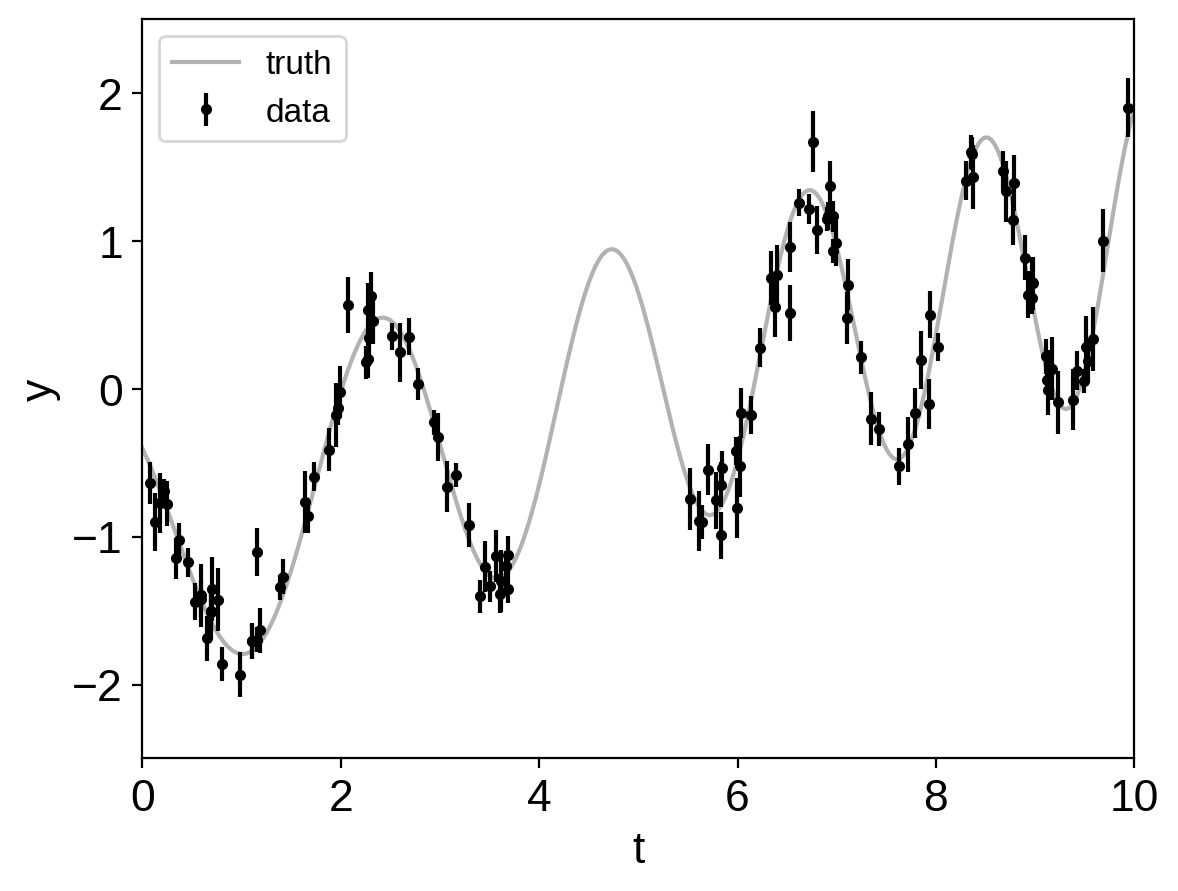

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

t = np.sort(
    np.append(np.random.uniform(0, 3.8, 57), np.random.uniform(5.5, 10, 68))
)  # The input coordinates must be sorted
yerr = np.random.uniform(0.08, 0.22, len(t))
y = (
    0.2 * (t - 5)
    + np.sin(3 * t + 0.1 * (t - 5) ** 2)
    + yerr * np.random.randn(len(t))
)

true_t = np.linspace(0, 10, 5000)
true_y = 0.2 * (true_t - 5) + np.sin(3 * true_t + 0.1 * (true_t - 5) ** 2)

plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label="data")
plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3, label="truth")
plt.legend(fontsize=12)
plt.xlabel("t")
plt.ylabel("y")
plt.xlim(0, 10)
_ = plt.ylim(-2.5, 2.5)

This plot shows the simulated data as black points with error bars and
the true function is shown as a gray line.

Now let's build the PyMC3 model that we'll use to fit the data.
We can see that there's some roughly periodic signal in the data as well
as a longer term trend. To capture these two features, we will model
this as a mixture of two stochastically driven simple harmonic
oscillators (SHO) with the power spectrum:

$$
S(\omega) = \sqrt{\frac{2}{\pi}}\frac{S_1\,{\omega_1}^4}{(\omega^2 - {\omega_1}^2)^2 + 2\,{\omega_1}^2\,\omega^2}
   + \sqrt{\frac{2}{\pi}}\frac{S_2\,{\omega_2}^4}{(\omega^2 - {\omega_2}^2)^2 + {\omega_2}^2\,\omega^2/Q^2}
$$

The first term is :class:`exoplanet.gp.terms.SHOterm` with $Q=1/\sqrt{2}$ and the second is regular :class:`exoplanet.gp.terms.SHOterm`.
This model has 5 free parameters ($S_1$, $\omega_1$, $S_2$, $\omega_2$, and $Q$) and they must all be positive so we'll fit for the log of each parameter.
Using *exoplanet*, this is how you would build this model,
choosing more or less arbitrary initial values for the parameters.

In [4]:
import pymc3 as pm
import theano.tensor as tt
from exoplanet.gp import terms, GP

with pm.Model() as model:

    mean = pm.Normal("mean", mu=0.0, sigma=1.0)
    logS1 = pm.Normal("logS1", mu=0.0, sigma=15.0, testval=np.log(np.var(y)))
    logw1 = pm.Normal("logw1", mu=0.0, sigma=15.0, testval=np.log(3.0))
    logS2 = pm.Normal("logS2", mu=0.0, sigma=15.0, testval=np.log(np.var(y)))
    logw2 = pm.Normal("logw2", mu=0.0, sigma=15.0, testval=np.log(3.0))
    logQ = pm.Normal("logQ", mu=0.0, sigma=15.0, testval=0)

    # Set up the kernel an GP
    kernel = terms.SHOTerm(log_S0=logS1, log_w0=logw1, Q=1.0 / np.sqrt(2))
    kernel += terms.SHOTerm(log_S0=logS2, log_w0=logw2, log_Q=logQ)
    gp = GP(kernel, t, yerr ** 2, mean=mean)

    # Condition the GP on the observations and add the marginal likelihood
    # to the model
    gp.marginal("gp", observed=y)

A few comments here:

1. The `term` interface in *exoplanet* only accepts keyword arguments with names given by the `parameter_names` property of the term. But it will also interpret keyword arguments with the name prefaced by `log_` to be the log of the parameter. For example, in this case, we used `log_S0` as the parameter for each term, but `S0=tt.exp(log_S0)` would have been equivalent. This is useful because many of the parameters are required to be positive so fitting the log of those parameters is often best.
2. The third argument to the :class:`exoplanet.gp.GP` constructor should be the *variance* to add along the diagonal, not the standard deviation as in the original [celerite implementation](https://celerite.readthedocs.io).
3. Finally, the :class:`exoplanet.gp.GP` constructor takes an optional argument `J` which specifies the width of the problem if it is known at compile time. Just to be confusing, this is actually two times the `J` from [the celerite paper](https://arxiv.org/abs/1703.09710). There are various technical reasons why this is difficult to work out in general and this code will always work if you don't provide a value for `J`, but you can get much better performance (especially for small `J`) if you know what it will be for your problem. In general, most terms cost `J=2` with the exception of a :class:`exoplanet.gp.terms.RealTerm` (which costs `J=1`) and a :class:`exoplanet.gp.terms.RotationTerm` (which costs `J=4`).

To start, let's fit for the maximum a posteriori (MAP) parameters and look the the predictions that those make.

In [5]:
import exoplanet as xo

with model:
    map_soln = xo.optimize(start=model.test_point)

optimizing logp for variables: [logQ, logw2, logS2, logw1, logS1, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-4.198757e+01]

1it [00:00, 256.30it/s, logp=-4.198757e+01]

2it [00:00, 337.96it/s, logp=-4.198757e+01]

3it [00:00, 384.09it/s, logp=-1.441157e+01]

4it [00:00, 398.30it/s, logp=-2.672791e+01]

5it [00:00, 422.54it/s, logp=-1.427864e+01]

6it [00:00, 430.53it/s, logp=-1.409530e+01]

7it [00:00, 442.73it/s, logp=-1.805457e+01]

8it [00:00, 456.68it/s, logp=-1.408273e+01]

9it [00:00, 449.34it/s, logp=-1.406092e+01]

10it [00:00, 455.72it/s, logp=-1.403897e+01]

11it [00:00, 457.58it/s, logp=-1.401718e+01]

12it [00:00, 458.51it/s, logp=-1.398992e+01]

13it [00:00, 468.34it/s, logp=-1.369576e+01]

14it [00:00, 469.69it/s, logp=-9.453963e+00]

15it [00:00, 474.43it/s, logp=-1.319547e+01]

16it [00:00, 479.33it/s, logp=-8.622752e+00]

17it [00:00, 479.53it/s, logp=-3.102277e+03]

18it [00:00, 483.24it/s, logp=-1.311072e+03]

19it [00:00, 487.17it/s, logp=-8.622735e+00]

20it [00:00, 491.05it/s, logp=-8.621741e+00]

21it [00:00, 489.95it/s, logp=-8.619706e+00]

22it [00:00, 487.39it/s, logp=-8.611686e+00]

23it [00:00, 490.70it/s, logp=-8.581492e+00]

24it [00:00, 486.76it/s, logp=-8.503609e+00]

25it [00:00, 488.02it/s, logp=-8.255922e+00]

26it [00:00, 485.76it/s, logp=-7.761946e+00]

27it [00:00, 486.96it/s, logp=-6.973436e+00]

28it [00:00, 489.43it/s, logp=-5.886489e+00]

29it [00:00, 484.58it/s, logp=-5.302811e+00]

30it [00:00, 485.56it/s, logp=-4.928446e+00]

31it [00:00, 485.55it/s, logp=-4.643987e+00]

32it [00:00, 485.07it/s, logp=-4.476585e+00]

33it [00:00, 484.30it/s, logp=-4.186604e+00]

34it [00:00, 484.59it/s, logp=-3.779905e+00]

35it [00:00, 486.66it/s, logp=-3.392963e+00]

36it [00:00, 488.22it/s, logp=-3.003613e+00]

37it [00:00, 488.98it/s, logp=-2.776250e+00]

38it [00:00, 489.43it/s, logp=-2.644675e+00]

39it [00:00, 491.21it/s, logp=-2.581213e+00]

40it [00:00, 491.03it/s, logp=-2.571695e+00]

41it [00:00, 490.32it/s, logp=-2.570057e+00]

42it [00:00, 492.12it/s, logp=-2.569910e+00]

43it [00:00, 491.18it/s, logp=-2.569898e+00]

44it [00:00, 491.19it/s, logp=-2.569894e+00]

45it [00:00, 491.48it/s, logp=-2.569893e+00]

46it [00:00, 490.22it/s, logp=-2.569892e+00]

47it [00:00, 489.05it/s, logp=-2.569892e+00]

48it [00:00, 487.37it/s, logp=-2.569892e+00]

49it [00:00, 487.51it/s, logp=-2.569892e+00]

50it [00:00, 494.60it/s, logp=-2.569892e+00]

50it [00:00, 71.74it/s, logp=-2.569892e+00] 


message: Optimization terminated successfully.
logp: -41.9875698144546 -> -2.569892168573091


We'll use the :func:`exoplanet.eval_in_model` function to evaluate the MAP GP model.

In [6]:
with model:
    mu, var = xo.eval_in_model(
        gp.predict(true_t, return_var=True, predict_mean=True), map_soln
    )

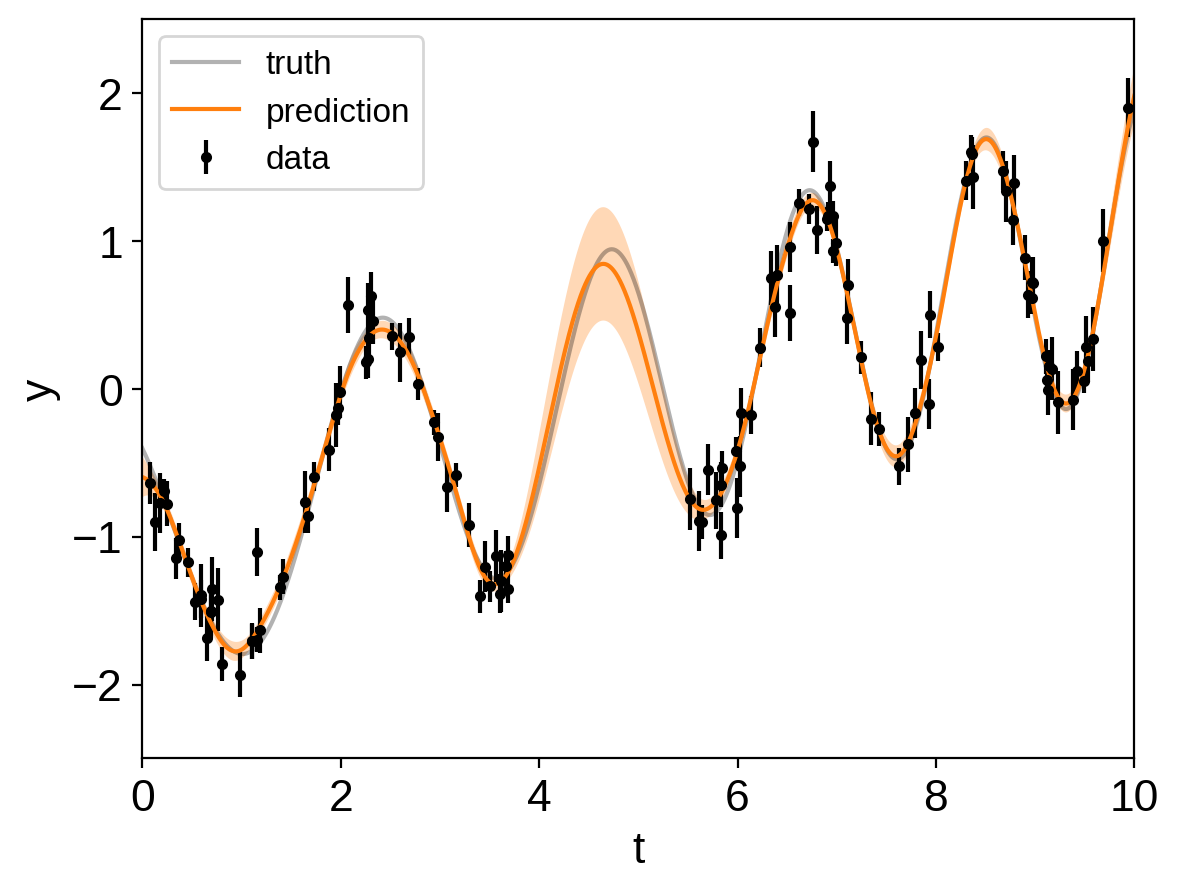

In [7]:
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label="data")
plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3, label="truth")

# Plot the prediction and the 1-sigma uncertainty
sd = np.sqrt(var)
art = plt.fill_between(true_t, mu + sd, mu - sd, color="C1", alpha=0.3)
art.set_edgecolor("none")
plt.plot(true_t, mu, color="C1", label="prediction")

plt.legend(fontsize=12)
plt.xlabel("t")
plt.ylabel("y")
plt.xlim(0, 10)
_ = plt.ylim(-2.5, 2.5)

Now we can sample this model using PyMC3.
There are strong covariances between the parameters so we'll use the custom :func:`exoplanet.get_dense_nuts_step` to fit for these covariances during burn-in.

In [8]:
with model:
    trace = pm.sample(
        tune=2000,
        draws=2000,
        start=map_soln,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logQ, logw2, logS2, logw1, logS1, mean]


Sampling 2 chains, 0 divergences:   0%|          | 0/8000 [00:00<?, ?draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 5/8000 [00:00<05:41, 23.40draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 7/8000 [00:00<06:05, 21.88draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 9/8000 [00:00<06:43, 19.78draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 11/8000 [00:00<06:45, 19.71draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 13/8000 [00:00<06:48, 19.55draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 16/8000 [00:00<06:11, 21.52draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 20/8000 [00:00<05:22, 24.75draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 26/8000 [00:00<04:26, 29.95draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 31/8000 [00:01<04:12, 31.54draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 36/8000 [00:01<03:54, 33.91draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 42/8000 [00:01<03:32, 37.52draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 49/8000 [00:01<03:04, 43.11draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 54/8000 [00:01<02:58, 44.57draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 59/8000 [00:01<03:25, 38.60draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 64/8000 [00:01<03:32, 37.34draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 69/8000 [00:01<03:26, 38.45draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 76/8000 [00:02<03:19, 39.65draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 81/8000 [00:02<04:23, 30.07draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 85/8000 [00:02<04:13, 31.18draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 89/8000 [00:02<04:00, 32.84draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 99/8000 [00:02<03:13, 40.84draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 107/8000 [00:02<02:50, 46.38draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 113/8000 [00:02<02:54, 45.24draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 121/8000 [00:03<02:35, 50.67draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 127/8000 [00:03<02:31, 52.02draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 133/8000 [00:03<02:51, 45.76draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 139/8000 [00:03<03:04, 42.67draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 145/8000 [00:03<02:58, 44.11draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 155/8000 [00:03<02:28, 52.79draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 164/8000 [00:03<02:10, 59.94draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 171/8000 [00:03<02:05, 62.39draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 178/8000 [00:04<02:02, 63.63draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 185/8000 [00:04<02:03, 63.40draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 197/8000 [00:04<01:48, 72.08draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 209/8000 [00:04<01:35, 81.20draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 222/8000 [00:04<01:27, 89.34draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 237/8000 [00:04<01:17, 99.88draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 256/8000 [00:04<01:06, 116.08draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 272/8000 [00:04<01:01, 125.55draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 292/8000 [00:04<00:54, 140.43draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 310/8000 [00:05<00:51, 148.68draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 331/8000 [00:05<00:47, 160.11draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 350/8000 [00:05<00:45, 166.91draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 374/8000 [00:05<00:41, 182.60draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 394/8000 [00:05<00:41, 182.86draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 414/8000 [00:05<00:41, 184.02draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 436/8000 [00:05<00:39, 192.74draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 458/8000 [00:05<00:38, 197.73draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 479/8000 [00:05<00:39, 190.07draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 499/8000 [00:06<00:40, 184.58draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 523/8000 [00:06<00:37, 197.78draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 545/8000 [00:06<00:36, 202.97draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 566/8000 [00:06<00:36, 201.60draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 587/8000 [00:06<00:36, 203.14draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 608/8000 [00:06<00:36, 200.69draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 629/8000 [00:06<00:39, 184.97draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 648/8000 [00:06<00:43, 169.03draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 666/8000 [00:06<00:45, 159.82draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 689/8000 [00:07<00:41, 175.18draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 708/8000 [00:07<00:43, 169.39draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 729/8000 [00:07<00:40, 178.75draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 751/8000 [00:07<00:38, 189.36draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 771/8000 [00:07<00:38, 189.51draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 791/8000 [00:07<00:37, 192.01draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 814/8000 [00:07<00:36, 198.89draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 837/8000 [00:07<00:35, 203.33draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 859/8000 [00:07<00:34, 208.01draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 880/8000 [00:07<00:34, 206.77draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 901/8000 [00:08<00:34, 206.12draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 922/8000 [00:08<00:34, 206.67draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 944/8000 [00:08<00:33, 208.20draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 968/8000 [00:08<00:32, 216.26draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 990/8000 [00:08<00:33, 208.83draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1012/8000 [00:08<00:34, 201.43draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1036/8000 [00:08<00:33, 210.67draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1058/8000 [00:08<00:34, 200.49draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 1083/8000 [00:08<00:32, 212.32draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 1106/8000 [00:09<00:32, 210.21draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 1128/8000 [00:09<00:34, 201.99draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 1151/8000 [00:09<00:32, 207.92draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 1173/8000 [00:09<00:33, 202.89draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 1197/8000 [00:09<00:32, 211.96draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 1219/8000 [00:09<00:32, 208.94draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 1241/8000 [00:09<00:32, 207.43draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 1262/8000 [00:09<00:33, 201.53draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 1284/8000 [00:09<00:33, 203.10draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 1310/8000 [00:10<00:30, 217.11draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 1333/8000 [00:10<00:32, 203.79draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 1354/8000 [00:10<00:32, 204.30draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 1375/8000 [00:10<00:32, 202.87draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 1396/8000 [00:10<00:33, 195.43draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 1418/8000 [00:10<00:33, 198.66draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 1444/8000 [00:10<00:30, 213.26draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 1469/8000 [00:10<00:29, 222.15draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 1495/8000 [00:10<00:28, 224.63draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 1518/8000 [00:11<00:33, 193.29draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 1542/8000 [00:11<00:31, 204.93draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 1565/8000 [00:11<00:30, 208.88draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 1588/8000 [00:11<00:30, 209.96draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 1610/8000 [00:11<00:32, 197.68draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 1631/8000 [00:11<00:33, 191.47draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 1651/8000 [00:11<00:32, 193.36draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 1671/8000 [00:11<00:33, 191.76draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 1691/8000 [00:11<00:33, 189.02draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 1712/8000 [00:12<00:32, 193.66draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 1733/8000 [00:12<00:31, 197.01draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 1759/8000 [00:12<00:29, 210.25draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 1781/8000 [00:12<00:30, 205.77draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 1802/8000 [00:12<00:31, 197.30draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 1822/8000 [00:12<00:33, 183.54draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 1841/8000 [00:12<00:35, 175.85draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 1859/8000 [00:12<00:34, 176.75draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 1881/8000 [00:12<00:33, 182.15draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 1900/8000 [00:13<00:34, 178.00draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 1924/8000 [00:13<00:31, 191.08draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 1945/8000 [00:13<00:31, 195.17draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 1967/8000 [00:13<00:30, 200.33draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 1990/8000 [00:13<00:28, 207.58draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 2015/8000 [00:13<00:27, 216.75draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 2039/8000 [00:13<00:26, 222.57draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 2062/8000 [00:13<00:28, 211.39draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 2084/8000 [00:13<00:30, 192.01draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 2104/8000 [00:14<00:30, 192.06draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 2126/8000 [00:14<00:29, 196.07draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 2146/8000 [00:14<00:29, 195.65draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 2166/8000 [00:14<00:31, 183.75draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 2185/8000 [00:14<00:33, 174.12draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 2204/8000 [00:14<00:32, 175.69draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 2225/8000 [00:14<00:32, 179.63draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 2245/8000 [00:14<00:31, 182.43draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 2264/8000 [00:14<00:31, 182.18draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 2283/8000 [00:15<00:31, 182.99draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 2303/8000 [00:15<00:31, 182.78draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 2322/8000 [00:15<00:31, 181.33draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 2341/8000 [00:15<00:31, 180.03draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 2363/8000 [00:15<00:29, 189.97draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 2383/8000 [00:15<00:30, 186.47draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 2402/8000 [00:15<00:31, 180.10draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 2426/8000 [00:15<00:29, 191.88draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 2448/8000 [00:15<00:28, 197.21draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 2475/8000 [00:15<00:25, 214.31draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 2498/8000 [00:16<00:25, 215.55draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 2523/8000 [00:16<00:24, 223.21draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 2546/8000 [00:16<00:26, 204.61draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 2570/8000 [00:16<00:25, 213.47draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 2592/8000 [00:16<00:25, 213.11draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 2615/8000 [00:16<00:25, 215.29draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 2637/8000 [00:16<00:26, 201.93draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 2658/8000 [00:16<00:27, 196.14draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 2679/8000 [00:16<00:26, 198.87draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 2702/8000 [00:17<00:26, 203.77draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 2723/8000 [00:17<00:26, 201.66draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 2746/8000 [00:17<00:25, 208.65draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 2768/8000 [00:17<00:25, 205.41draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 2789/8000 [00:17<00:26, 195.10draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 2809/8000 [00:17<00:27, 189.98draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 2829/8000 [00:17<00:28, 184.27draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 2851/8000 [00:17<00:26, 191.52draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 2878/8000 [00:17<00:24, 208.68draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 2902/8000 [00:18<00:23, 214.79draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 2926/8000 [00:18<00:22, 221.31draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 2949/8000 [00:18<00:22, 222.78draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 2972/8000 [00:18<00:23, 217.61draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 2998/8000 [00:18<00:21, 228.23draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 3022/8000 [00:18<00:23, 214.15draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 3044/8000 [00:18<00:24, 206.35draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 3066/8000 [00:18<00:23, 208.51draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 3091/8000 [00:18<00:22, 219.00draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 3115/8000 [00:19<00:21, 222.81draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 3138/8000 [00:19<00:21, 221.35draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 3161/8000 [00:19<00:21, 223.27draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 3184/8000 [00:19<00:22, 218.22draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 3206/8000 [00:19<00:23, 203.59draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 3228/8000 [00:19<00:23, 206.58draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 3249/8000 [00:19<00:23, 206.20draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 3270/8000 [00:19<00:24, 195.93draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 3290/8000 [00:19<00:23, 196.51draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 3314/8000 [00:19<00:22, 205.39draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 3335/8000 [00:20<00:23, 202.15draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 3356/8000 [00:20<00:25, 184.78draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 3377/8000 [00:20<00:24, 191.36draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 3398/8000 [00:20<00:23, 192.94draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 3418/8000 [00:20<00:23, 192.70draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 3440/8000 [00:20<00:23, 196.13draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 3460/8000 [00:20<00:24, 187.82draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 3484/8000 [00:20<00:22, 199.63draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 3505/8000 [00:20<00:22, 199.87draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 3526/8000 [00:21<00:22, 198.17draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 3546/8000 [00:21<00:22, 196.35draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 3569/8000 [00:21<00:21, 203.10draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 3594/8000 [00:21<00:20, 212.44draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 3616/8000 [00:21<00:20, 213.75draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 3638/8000 [00:21<00:21, 205.02draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 3661/8000 [00:21<00:20, 211.04draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 3683/8000 [00:21<00:21, 202.57draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 3704/8000 [00:21<00:23, 184.27draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 3723/8000 [00:22<00:24, 175.62draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 3741/8000 [00:22<00:24, 175.41draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 3762/8000 [00:22<00:23, 182.79draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 3782/8000 [00:22<00:22, 187.32draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 3801/8000 [00:22<00:23, 181.44draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 3823/8000 [00:22<00:22, 189.48draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 3843/8000 [00:22<00:21, 188.96draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 3865/8000 [00:22<00:21, 195.17draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 3885/8000 [00:22<00:21, 194.46draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 3911/8000 [00:23<00:19, 208.59draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 3933/8000 [00:23<00:19, 206.11draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 3955/8000 [00:23<00:19, 208.29draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 3977/8000 [00:23<00:19, 203.53draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 3998/8000 [00:23<00:21, 190.12draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 4018/8000 [00:23<00:24, 163.49draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 4036/8000 [00:23<00:28, 141.14draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 4052/8000 [00:23<00:29, 135.05draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 4068/8000 [00:24<00:27, 141.44draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 4084/8000 [00:24<00:27, 143.96draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 4100/8000 [00:24<00:26, 146.42draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 4115/8000 [00:24<00:26, 144.75draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 4133/8000 [00:24<00:25, 153.15draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 4149/8000 [00:24<00:25, 148.95draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 4165/8000 [00:24<00:26, 146.07draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 4187/8000 [00:24<00:23, 161.81draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 4210/8000 [00:24<00:21, 175.89draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 4233/8000 [00:25<00:20, 187.90draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 4255/8000 [00:25<00:19, 195.17draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 4277/8000 [00:25<00:18, 201.15draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 4298/8000 [00:25<00:18, 201.06draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 4319/8000 [00:25<00:18, 199.31draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 4341/8000 [00:25<00:18, 201.69draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 4363/8000 [00:25<00:17, 202.58draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 4387/8000 [00:25<00:17, 210.67draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 4409/8000 [00:25<00:17, 209.43draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 4431/8000 [00:25<00:17, 207.00draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 4454/8000 [00:26<00:16, 209.99draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 4476/8000 [00:26<00:17, 206.89draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 4501/8000 [00:26<00:16, 217.68draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 4525/8000 [00:26<00:15, 221.87draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 4548/8000 [00:26<00:15, 216.09draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 4570/8000 [00:26<00:16, 214.36draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 4592/8000 [00:26<00:16, 208.55draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 4615/8000 [00:26<00:15, 212.92draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 4637/8000 [00:26<00:16, 203.82draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 4658/8000 [00:27<00:16, 196.65draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 4684/8000 [00:27<00:15, 209.49draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 4708/8000 [00:27<00:15, 214.30draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 4732/8000 [00:27<00:14, 220.93draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 4755/8000 [00:27<00:14, 220.81draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 4778/8000 [00:27<00:15, 212.58draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 4800/8000 [00:27<00:15, 200.79draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 4821/8000 [00:27<00:15, 199.05draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 4844/8000 [00:27<00:15, 206.99draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 4865/8000 [00:28<00:15, 205.97draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 4890/8000 [00:28<00:14, 214.20draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 4912/8000 [00:28<00:14, 211.90draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 4934/8000 [00:28<00:14, 212.10draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 4956/8000 [00:28<00:14, 204.81draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 4980/8000 [00:28<00:14, 212.07draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 5004/8000 [00:28<00:13, 219.31draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 5027/8000 [00:28<00:13, 215.21draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 5049/8000 [00:28<00:14, 206.61draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 5070/8000 [00:28<00:14, 203.28draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▎   | 5092/8000 [00:29<00:13, 208.02draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 5116/8000 [00:29<00:13, 215.12draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 5138/8000 [00:29<00:13, 205.01draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 5159/8000 [00:29<00:13, 205.98draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 5182/8000 [00:29<00:13, 206.66draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 5203/8000 [00:29<00:14, 198.19draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 5224/8000 [00:29<00:13, 200.66draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 5247/8000 [00:29<00:13, 208.43draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 5268/8000 [00:29<00:14, 193.09draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 5288/8000 [00:30<00:14, 191.89draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 5310/8000 [00:30<00:13, 196.14draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 5332/8000 [00:30<00:13, 200.39draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 5355/8000 [00:30<00:12, 205.29draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 5376/8000 [00:30<00:12, 202.36draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 5397/8000 [00:30<00:13, 195.69draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 5418/8000 [00:30<00:12, 199.43draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 5439/8000 [00:30<00:12, 197.49draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 5459/8000 [00:30<00:13, 193.32draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 5479/8000 [00:31<00:13, 192.60draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 5503/8000 [00:31<00:12, 204.01draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 5524/8000 [00:31<00:12, 199.12draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 5545/8000 [00:31<00:12, 198.14draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 5567/8000 [00:31<00:12, 202.09draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 5590/8000 [00:31<00:11, 208.91draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 5612/8000 [00:31<00:11, 209.43draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 5635/8000 [00:31<00:11, 213.12draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 5659/8000 [00:31<00:10, 216.50draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 5682/8000 [00:31<00:10, 216.67draws/s]

Sampling 2 chains, 0 divergences:  71%|███████▏  | 5704/8000 [00:32<00:10, 214.94draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 5728/8000 [00:32<00:10, 220.29draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 5751/8000 [00:32<00:10, 215.79draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 5773/8000 [00:32<00:10, 210.06draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 5795/8000 [00:32<00:10, 205.68draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 5818/8000 [00:32<00:10, 210.87draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 5840/8000 [00:32<00:10, 213.44draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 5862/8000 [00:32<00:10, 198.60draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▎  | 5885/8000 [00:32<00:10, 203.25draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 5907/8000 [00:33<00:10, 205.43draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 5929/8000 [00:33<00:10, 206.48draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 5950/8000 [00:33<00:09, 206.94draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 5972/8000 [00:33<00:09, 208.22draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 5993/8000 [00:33<00:09, 204.60draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 6014/8000 [00:33<00:09, 199.51draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 6035/8000 [00:33<00:09, 201.07draws/s]

Sampling 2 chains, 1 divergences:  75%|███████▌  | 6038/8000 [00:33<00:09, 201.07draws/s]

Sampling 2 chains, 1 divergences:  76%|███████▌  | 6057/8000 [00:33<00:09, 204.96draws/s]

Sampling 2 chains, 1 divergences:  76%|███████▌  | 6078/8000 [00:33<00:09, 201.01draws/s]

Sampling 2 chains, 1 divergences:  76%|███████▋  | 6100/8000 [00:34<00:09, 205.82draws/s]

Sampling 2 chains, 1 divergences:  77%|███████▋  | 6121/8000 [00:34<00:09, 197.55draws/s]

Sampling 2 chains, 1 divergences:  77%|███████▋  | 6142/8000 [00:34<00:09, 201.08draws/s]

Sampling 2 chains, 1 divergences:  77%|███████▋  | 6163/8000 [00:34<00:09, 199.80draws/s]

Sampling 2 chains, 1 divergences:  77%|███████▋  | 6184/8000 [00:34<00:09, 201.02draws/s]

Sampling 2 chains, 1 divergences:  78%|███████▊  | 6205/8000 [00:34<00:09, 197.47draws/s]

Sampling 2 chains, 1 divergences:  78%|███████▊  | 6226/8000 [00:34<00:08, 200.62draws/s]

Sampling 2 chains, 1 divergences:  78%|███████▊  | 6247/8000 [00:34<00:08, 197.52draws/s]

Sampling 2 chains, 1 divergences:  78%|███████▊  | 6269/8000 [00:34<00:08, 200.79draws/s]

Sampling 2 chains, 1 divergences:  79%|███████▊  | 6292/8000 [00:34<00:08, 208.38draws/s]

Sampling 2 chains, 1 divergences:  79%|███████▉  | 6314/8000 [00:35<00:07, 211.11draws/s]

Sampling 2 chains, 1 divergences:  79%|███████▉  | 6337/8000 [00:35<00:07, 214.70draws/s]

Sampling 2 chains, 1 divergences:  79%|███████▉  | 6359/8000 [00:35<00:07, 212.63draws/s]

Sampling 2 chains, 1 divergences:  80%|███████▉  | 6381/8000 [00:35<00:08, 201.50draws/s]

Sampling 2 chains, 1 divergences:  80%|████████  | 6404/8000 [00:35<00:07, 207.65draws/s]

Sampling 2 chains, 1 divergences:  80%|████████  | 6425/8000 [00:35<00:07, 200.89draws/s]

Sampling 2 chains, 1 divergences:  81%|████████  | 6447/8000 [00:35<00:07, 202.04draws/s]

Sampling 2 chains, 1 divergences:  81%|████████  | 6469/8000 [00:35<00:07, 206.56draws/s]

Sampling 2 chains, 1 divergences:  81%|████████  | 6490/8000 [00:35<00:07, 206.41draws/s]

Sampling 2 chains, 1 divergences:  81%|████████▏ | 6514/8000 [00:36<00:07, 210.48draws/s]

Sampling 2 chains, 1 divergences:  82%|████████▏ | 6536/8000 [00:36<00:07, 207.43draws/s]

Sampling 2 chains, 1 divergences:  82%|████████▏ | 6560/8000 [00:36<00:06, 216.04draws/s]

Sampling 2 chains, 1 divergences:  82%|████████▏ | 6584/8000 [00:36<00:06, 219.06draws/s]

Sampling 2 chains, 1 divergences:  83%|████████▎ | 6609/8000 [00:36<00:06, 225.78draws/s]

Sampling 2 chains, 1 divergences:  83%|████████▎ | 6632/8000 [00:36<00:06, 218.39draws/s]

Sampling 2 chains, 1 divergences:  83%|████████▎ | 6654/8000 [00:36<00:06, 208.23draws/s]

Sampling 2 chains, 1 divergences:  83%|████████▎ | 6676/8000 [00:36<00:06, 206.72draws/s]

Sampling 2 chains, 1 divergences:  84%|████████▎ | 6697/8000 [00:36<00:06, 204.50draws/s]

Sampling 2 chains, 1 divergences:  84%|████████▍ | 6718/8000 [00:36<00:06, 203.15draws/s]

Sampling 2 chains, 1 divergences:  84%|████████▍ | 6740/8000 [00:37<00:06, 204.35draws/s]

Sampling 2 chains, 2 divergences:  84%|████████▍ | 6744/8000 [00:37<00:06, 204.35draws/s]

Sampling 2 chains, 2 divergences:  85%|████████▍ | 6761/8000 [00:37<00:06, 202.07draws/s]

Sampling 2 chains, 2 divergences:  85%|████████▍ | 6787/8000 [00:37<00:05, 215.92draws/s]

Sampling 2 chains, 2 divergences:  85%|████████▌ | 6811/8000 [00:37<00:05, 219.41draws/s]

Sampling 2 chains, 2 divergences:  85%|████████▌ | 6834/8000 [00:37<00:05, 218.50draws/s]

Sampling 2 chains, 2 divergences:  86%|████████▌ | 6858/8000 [00:37<00:05, 221.14draws/s]

Sampling 2 chains, 2 divergences:  86%|████████▌ | 6881/8000 [00:37<00:05, 213.35draws/s]

Sampling 2 chains, 2 divergences:  86%|████████▋ | 6903/8000 [00:37<00:05, 208.21draws/s]

Sampling 2 chains, 2 divergences:  87%|████████▋ | 6925/8000 [00:37<00:05, 211.26draws/s]

Sampling 2 chains, 2 divergences:  87%|████████▋ | 6947/8000 [00:38<00:04, 211.81draws/s]

Sampling 2 chains, 2 divergences:  87%|████████▋ | 6969/8000 [00:38<00:05, 205.77draws/s]

Sampling 2 chains, 2 divergences:  87%|████████▋ | 6993/8000 [00:38<00:04, 214.18draws/s]

Sampling 2 chains, 2 divergences:  88%|████████▊ | 7020/8000 [00:38<00:04, 226.37draws/s]

Sampling 2 chains, 2 divergences:  88%|████████▊ | 7044/8000 [00:38<00:04, 229.21draws/s]

Sampling 2 chains, 2 divergences:  88%|████████▊ | 7068/8000 [00:38<00:04, 218.81draws/s]

Sampling 2 chains, 2 divergences:  89%|████████▊ | 7091/8000 [00:38<00:04, 217.19draws/s]

Sampling 2 chains, 2 divergences:  89%|████████▉ | 7113/8000 [00:38<00:04, 211.95draws/s]

Sampling 2 chains, 2 divergences:  89%|████████▉ | 7135/8000 [00:38<00:04, 207.18draws/s]

Sampling 2 chains, 2 divergences:  89%|████████▉ | 7156/8000 [00:39<00:04, 207.57draws/s]

Sampling 2 chains, 2 divergences:  90%|████████▉ | 7177/8000 [00:39<00:04, 194.15draws/s]

Sampling 2 chains, 2 divergences:  90%|████████▉ | 7199/8000 [00:39<00:04, 198.60draws/s]

Sampling 2 chains, 2 divergences:  90%|█████████ | 7220/8000 [00:39<00:03, 196.53draws/s]

Sampling 2 chains, 2 divergences:  90%|█████████ | 7240/8000 [00:39<00:03, 196.10draws/s]

Sampling 2 chains, 2 divergences:  91%|█████████ | 7261/8000 [00:39<00:03, 199.59draws/s]

Sampling 2 chains, 2 divergences:  91%|█████████ | 7283/8000 [00:39<00:03, 203.19draws/s]

Sampling 2 chains, 2 divergences:  91%|█████████▏| 7305/8000 [00:39<00:03, 204.49draws/s]

Sampling 2 chains, 2 divergences:  92%|█████████▏| 7328/8000 [00:39<00:03, 211.05draws/s]

Sampling 2 chains, 2 divergences:  92%|█████████▏| 7354/8000 [00:39<00:02, 220.86draws/s]

Sampling 2 chains, 2 divergences:  92%|█████████▏| 7377/8000 [00:40<00:03, 206.75draws/s]

Sampling 2 chains, 3 divergences:  92%|█████████▏| 7383/8000 [00:40<00:02, 206.75draws/s]

Sampling 2 chains, 4 divergences:  92%|█████████▏| 7393/8000 [00:40<00:02, 206.75draws/s]

Sampling 2 chains, 5 divergences:  92%|█████████▏| 7397/8000 [00:40<00:02, 206.75draws/s]

Sampling 2 chains, 5 divergences:  92%|█████████▏| 7398/8000 [00:40<00:02, 202.97draws/s]

Sampling 2 chains, 6 divergences:  92%|█████████▏| 7399/8000 [00:40<00:02, 202.97draws/s]

Sampling 2 chains, 7 divergences:  93%|█████████▎| 7401/8000 [00:40<00:02, 202.97draws/s]

Sampling 2 chains, 8 divergences:  93%|█████████▎| 7404/8000 [00:40<00:02, 202.97draws/s]

Sampling 2 chains, 9 divergences:  93%|█████████▎| 7409/8000 [00:40<00:02, 202.97draws/s]

Sampling 2 chains, 10 divergences:  93%|█████████▎| 7418/8000 [00:40<00:02, 202.97draws/s]

Sampling 2 chains, 11 divergences:  93%|█████████▎| 7421/8000 [00:40<00:02, 202.97draws/s]

Sampling 2 chains, 11 divergences:  93%|█████████▎| 7422/8000 [00:40<00:02, 212.66draws/s]

Sampling 2 chains, 12 divergences:  93%|█████████▎| 7427/8000 [00:40<00:02, 212.66draws/s]

Sampling 2 chains, 13 divergences:  93%|█████████▎| 7429/8000 [00:40<00:02, 212.66draws/s]

Sampling 2 chains, 14 divergences:  93%|█████████▎| 7432/8000 [00:40<00:02, 212.66draws/s]

Sampling 2 chains, 15 divergences:  93%|█████████▎| 7434/8000 [00:40<00:02, 212.66draws/s]

Sampling 2 chains, 16 divergences:  93%|█████████▎| 7438/8000 [00:40<00:02, 212.66draws/s]

Sampling 2 chains, 17 divergences:  93%|█████████▎| 7440/8000 [00:40<00:02, 212.66draws/s]

Sampling 2 chains, 18 divergences:  93%|█████████▎| 7442/8000 [00:40<00:02, 212.66draws/s]

Sampling 2 chains, 19 divergences:  93%|█████████▎| 7443/8000 [00:40<00:02, 212.66draws/s]

Sampling 2 chains, 20 divergences:  93%|█████████▎| 7446/8000 [00:40<00:02, 212.66draws/s]

Sampling 2 chains, 20 divergences:  93%|█████████▎| 7448/8000 [00:40<00:02, 222.34draws/s]

Sampling 2 chains, 21 divergences:  93%|█████████▎| 7452/8000 [00:40<00:02, 222.34draws/s]

Sampling 2 chains, 22 divergences:  93%|█████████▎| 7456/8000 [00:40<00:02, 222.34draws/s]

Sampling 2 chains, 23 divergences:  93%|█████████▎| 7458/8000 [00:40<00:02, 222.34draws/s]

Sampling 2 chains, 24 divergences:  93%|█████████▎| 7460/8000 [00:40<00:02, 222.34draws/s]

Sampling 2 chains, 25 divergences:  93%|█████████▎| 7474/8000 [00:40<00:02, 222.34draws/s]

Sampling 2 chains, 26 divergences:  93%|█████████▎| 7475/8000 [00:40<00:02, 222.34draws/s]

Sampling 2 chains, 26 divergences:  93%|█████████▎| 7476/8000 [00:40<00:02, 236.71draws/s]

Sampling 2 chains, 27 divergences:  93%|█████████▎| 7476/8000 [00:40<00:02, 236.71draws/s]

Sampling 2 chains, 28 divergences:  94%|█████████▎| 7480/8000 [00:40<00:02, 236.71draws/s]

Sampling 2 chains, 29 divergences:  94%|█████████▎| 7481/8000 [00:40<00:02, 236.71draws/s]

Sampling 2 chains, 30 divergences:  94%|█████████▎| 7484/8000 [00:40<00:02, 236.71draws/s]

Sampling 2 chains, 31 divergences:  94%|█████████▎| 7489/8000 [00:40<00:02, 236.71draws/s]

Sampling 2 chains, 32 divergences:  94%|█████████▎| 7492/8000 [00:40<00:02, 236.71draws/s]

Sampling 2 chains, 33 divergences:  94%|█████████▎| 7496/8000 [00:40<00:02, 236.71draws/s]

Sampling 2 chains, 34 divergences:  94%|█████████▎| 7497/8000 [00:40<00:02, 236.71draws/s]

Sampling 2 chains, 34 divergences:  94%|█████████▍| 7501/8000 [00:40<00:02, 237.73draws/s]

Sampling 2 chains, 35 divergences:  94%|█████████▍| 7506/8000 [00:40<00:02, 237.73draws/s]

Sampling 2 chains, 36 divergences:  94%|█████████▍| 7512/8000 [00:40<00:02, 237.73draws/s]

Sampling 2 chains, 36 divergences:  94%|█████████▍| 7526/8000 [00:40<00:02, 214.82draws/s]

Sampling 2 chains, 36 divergences:  94%|█████████▍| 7552/8000 [00:40<00:02, 222.06draws/s]

Sampling 2 chains, 36 divergences:  95%|█████████▍| 7575/8000 [00:40<00:01, 222.71draws/s]

Sampling 2 chains, 36 divergences:  95%|█████████▍| 7598/8000 [00:41<00:01, 214.27draws/s]

Sampling 2 chains, 36 divergences:  95%|█████████▌| 7620/8000 [00:41<00:01, 212.85draws/s]

Sampling 2 chains, 36 divergences:  96%|█████████▌| 7642/8000 [00:41<00:01, 210.90draws/s]

Sampling 2 chains, 36 divergences:  96%|█████████▌| 7664/8000 [00:41<00:01, 207.77draws/s]

Sampling 2 chains, 36 divergences:  96%|█████████▌| 7685/8000 [00:41<00:01, 162.13draws/s]

Sampling 2 chains, 36 divergences:  96%|█████████▋| 7703/8000 [00:41<00:02, 136.42draws/s]

Sampling 2 chains, 36 divergences:  96%|█████████▋| 7719/8000 [00:41<00:02, 127.77draws/s]

Sampling 2 chains, 36 divergences:  97%|█████████▋| 7734/8000 [00:42<00:02, 124.97draws/s]

Sampling 2 chains, 36 divergences:  97%|█████████▋| 7748/8000 [00:42<00:02, 113.87draws/s]

Sampling 2 chains, 36 divergences:  97%|█████████▋| 7761/8000 [00:42<00:02, 109.58draws/s]

Sampling 2 chains, 36 divergences:  97%|█████████▋| 7773/8000 [00:42<00:02, 109.84draws/s]

Sampling 2 chains, 36 divergences:  97%|█████████▋| 7785/8000 [00:42<00:02, 100.93draws/s]

Sampling 2 chains, 36 divergences:  97%|█████████▋| 7796/8000 [00:42<00:02, 100.87draws/s]

Sampling 2 chains, 36 divergences:  98%|█████████▊| 7808/8000 [00:42<00:01, 104.32draws/s]

Sampling 2 chains, 36 divergences:  98%|█████████▊| 7819/8000 [00:42<00:01, 105.66draws/s]

Sampling 2 chains, 36 divergences:  98%|█████████▊| 7830/8000 [00:43<00:01, 104.12draws/s]

Sampling 2 chains, 36 divergences:  98%|█████████▊| 7841/8000 [00:43<00:01, 103.70draws/s]

Sampling 2 chains, 36 divergences:  98%|█████████▊| 7852/8000 [00:43<00:01, 102.10draws/s]

Sampling 2 chains, 36 divergences:  98%|█████████▊| 7863/8000 [00:43<00:01, 100.41draws/s]

Sampling 2 chains, 36 divergences:  98%|█████████▊| 7875/8000 [00:43<00:01, 102.73draws/s]

Sampling 2 chains, 36 divergences:  99%|█████████▊| 7886/8000 [00:43<00:01, 103.22draws/s]

Sampling 2 chains, 36 divergences:  99%|█████████▊| 7897/8000 [00:43<00:00, 103.23draws/s]

Sampling 2 chains, 36 divergences:  99%|█████████▉| 7908/8000 [00:43<00:00, 100.78draws/s]

Sampling 2 chains, 36 divergences:  99%|█████████▉| 7919/8000 [00:43<00:00, 103.04draws/s]

Sampling 2 chains, 36 divergences:  99%|█████████▉| 7930/8000 [00:44<00:00, 102.85draws/s]

Sampling 2 chains, 36 divergences:  99%|█████████▉| 7941/8000 [00:44<00:00, 100.74draws/s]

Sampling 2 chains, 36 divergences:  99%|█████████▉| 7952/8000 [00:44<00:00, 101.79draws/s]

Sampling 2 chains, 36 divergences: 100%|█████████▉| 7963/8000 [00:44<00:00, 100.96draws/s]

Sampling 2 chains, 36 divergences: 100%|█████████▉| 7974/8000 [00:44<00:00, 103.18draws/s]

Sampling 2 chains, 36 divergences: 100%|█████████▉| 7985/8000 [00:44<00:00, 96.94draws/s] 

Sampling 2 chains, 36 divergences: 100%|█████████▉| 7997/8000 [00:44<00:00, 100.91draws/s]

Sampling 2 chains, 36 divergences: 100%|██████████| 8000/8000 [00:44<00:00, 178.95draws/s]

There were 35 divergences after tuning. Increase `target_accept` or reparameterize.


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 10% for some parameters.


Now we can compute the standard PyMC3 convergence statistics (using `pymc3.summary`) and make a trace plot (using `pymc3.traceplot`).

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean,0.006,0.868,-1.719,1.568,0.017,0.017,2555.0,1306.0,2578.0,2294.0,1.00
logS1,5.189,3.471,-0.544,11.633,0.102,0.072,1156.0,1156.0,629.0,397.0,1.01
logw1,-2.528,1.324,-5.135,-0.076,0.063,0.045,442.0,442.0,377.0,119.0,1.01
logS2,-4.176,0.868,-4.993,-3.111,0.101,0.077,74.0,64.0,422.0,120.0,1.01
logw2,1.129,0.051,1.032,1.224,0.001,0.001,2137.0,2137.0,2351.0,1764.0,1.00
logQ,2.951,1.353,1.102,5.377,0.101,0.087,180.0,120.0,472.0,203.0,1.01


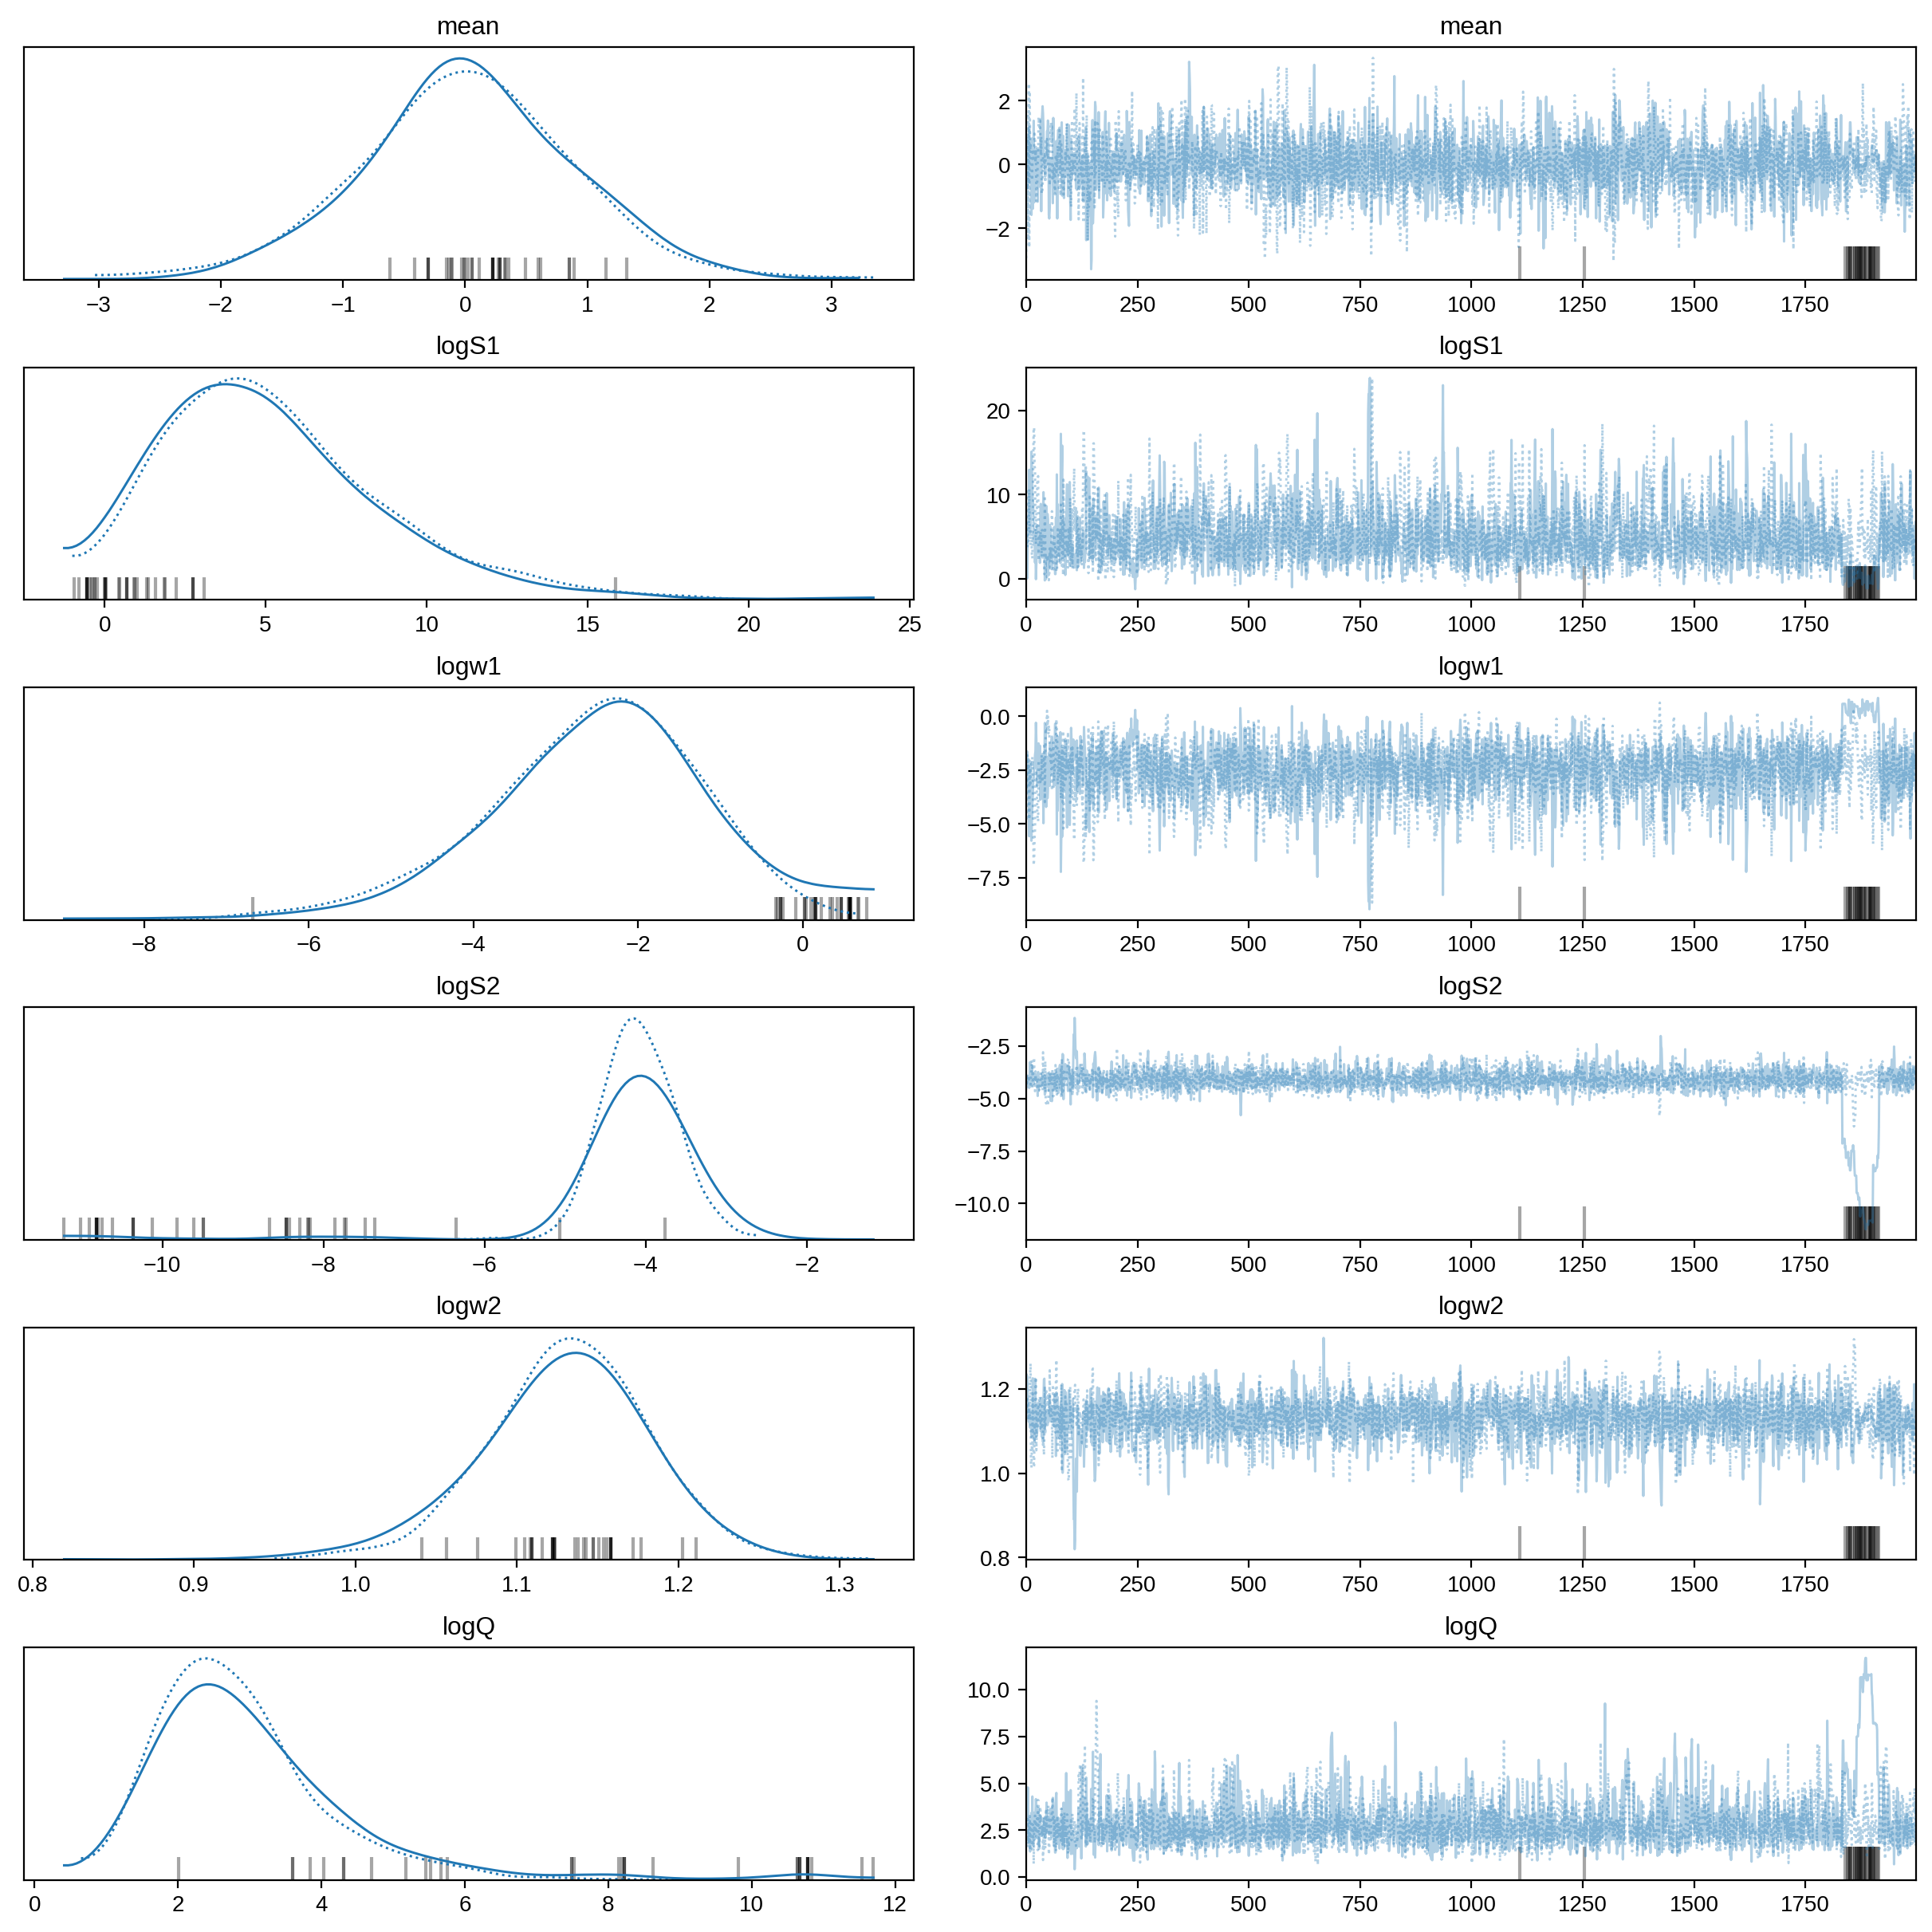

In [9]:
pm.traceplot(trace)
pm.summary(trace)

That all looks pretty good, but I like to make two other results plots: (1) a [corner plot](https://corner.readthedocs.io) and (2) a posterior predictive plot.

The corner plot is easy using `pymc3.trace_to_dataframe` and I find it useful for understanding the covariances between parameters when debugging.

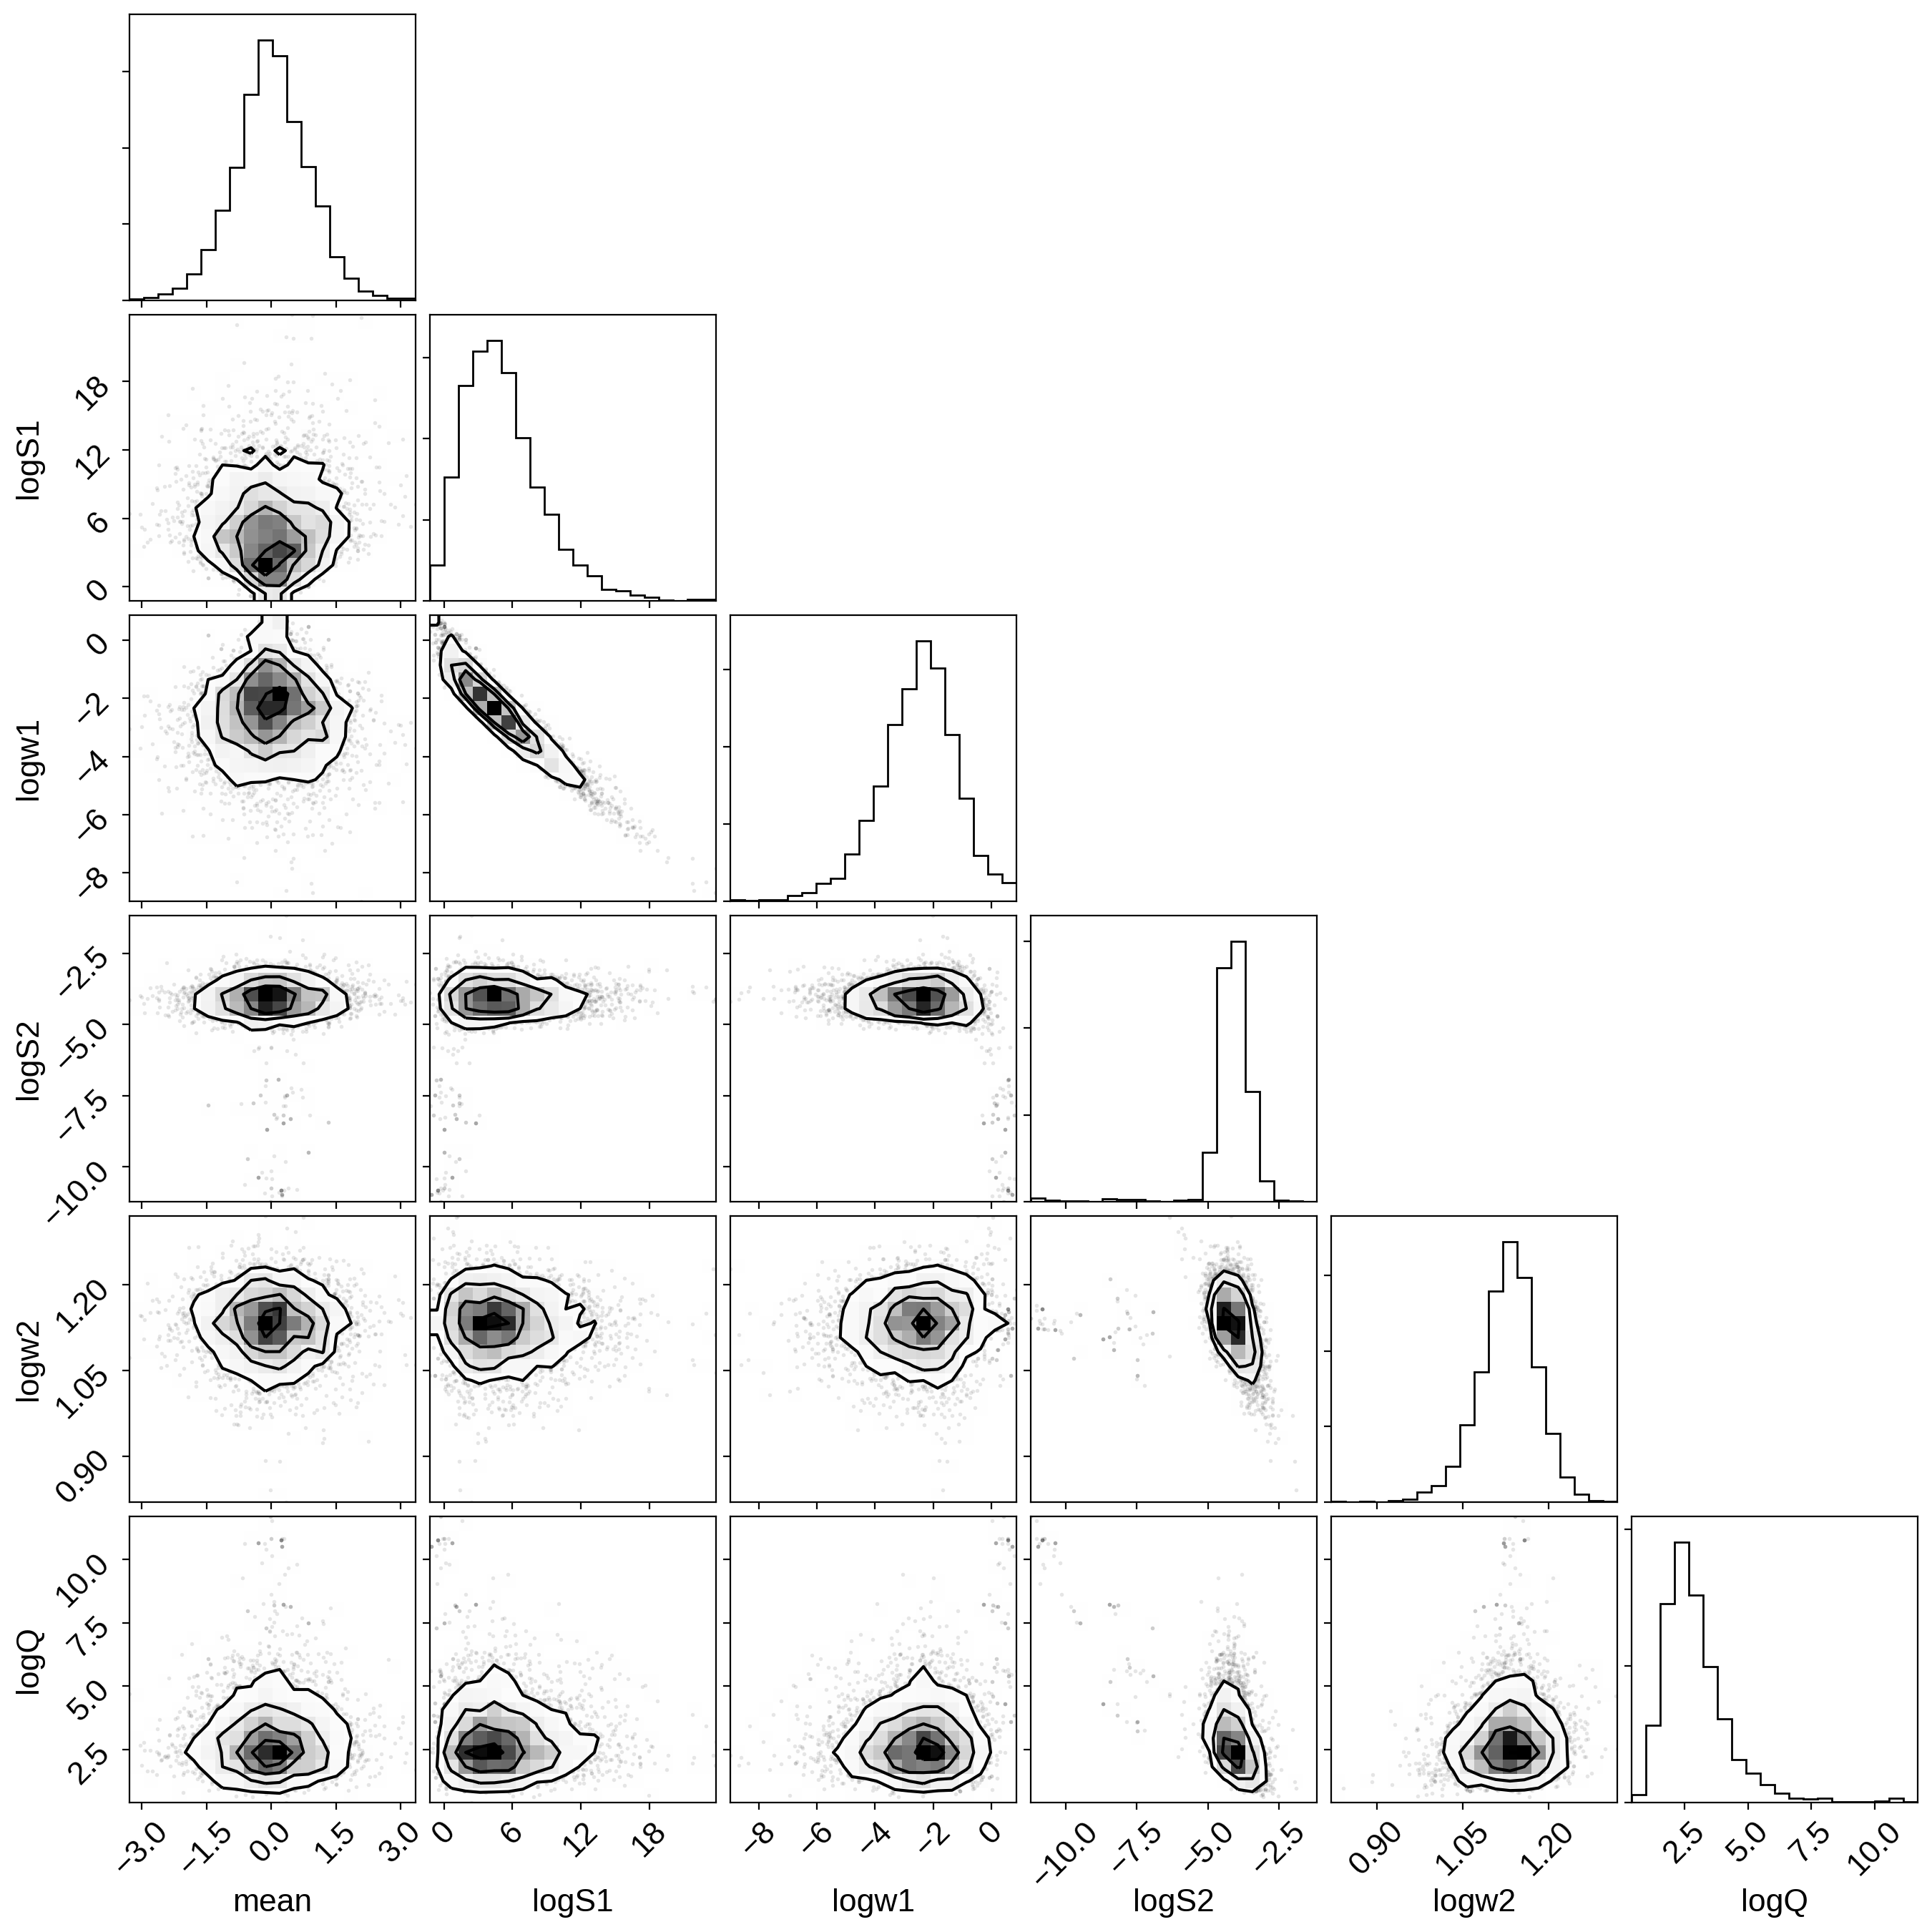

In [10]:
import corner

samples = pm.trace_to_dataframe(trace)
_ = corner.corner(samples)

The "posterior predictive" plot that I like to make isn't the same as a "posterior predictive check" (which can be a good thing to do too).
Instead, I like to look at the predictions of the model in the space of the data.
We could have saved these predictions using a `pymc3.Deterministic` distribution, but that adds some overhead to each evaluation of the model so instead, we can use :func:`exoplanet.utils.get_samples_from_trace` to loop over a few random samples from the chain and then the :func:`exoplanet.eval_in_model` function to evaluate the prediction just for those samples.

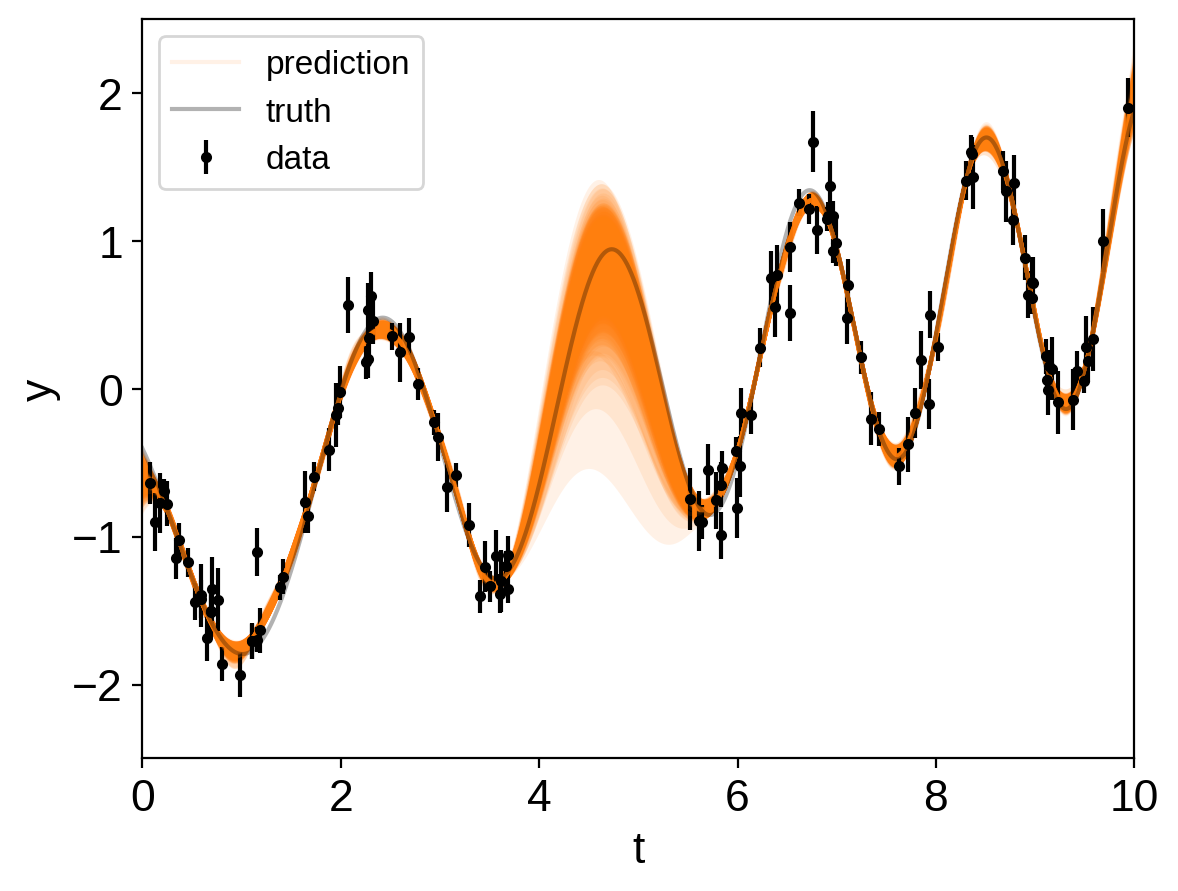

In [11]:
# Generate 50 realizations of the prediction sampling randomly from the chain
N_pred = 50
pred_mu = np.empty((N_pred, len(true_t)))
pred_var = np.empty((N_pred, len(true_t)))
with model:
    pred = gp.predict(true_t, return_var=True, predict_mean=True)
    for i, sample in enumerate(xo.get_samples_from_trace(trace, size=N_pred)):
        pred_mu[i], pred_var[i] = xo.eval_in_model(pred, sample)

# Plot the predictions
for i in range(len(pred_mu)):
    mu = pred_mu[i]
    sd = np.sqrt(pred_var[i])
    label = None if i else "prediction"
    art = plt.fill_between(true_t, mu + sd, mu - sd, color="C1", alpha=0.1)
    art.set_edgecolor("none")
    plt.plot(true_t, mu, color="C1", label=label, alpha=0.1)

plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label="data")
plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3, label="truth")
plt.legend(fontsize=12, loc=2)
plt.xlabel("t")
plt.ylabel("y")
plt.xlim(0, 10)
_ = plt.ylim(-2.5, 2.5)

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [12]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:exoplanet, exoplanet:foremanmackey17,
exoplanet:foremanmackey18, exoplanet:pymc3, exoplanet:theano}.


In [13]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Rodrigo Luger and
            Eric Agol and Geert Barentsen and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.3.0},
   month = apr,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
